In [245]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import dates
%matplotlib inline
plt.rcParams["figure.figsize"] = [30, 30]
import seaborn as sns

from datetime import datetime
from datetime import timedelta

from math import floor

from sklearn.preprocessing import StandardScaler

In [246]:
airports = pd.read_csv("airports.csv", usecols=["IATA_CODE", "AIRPORT", "CITY"])

airports.head()

,IATA_CODE,AIRPORT,CITY
0,ABE,Lehigh Valley International Airport,Allentown
1,ABI,Abilene Regional Airport,Abilene
2,ABQ,Albuquerque International Sunport,Albuquerque
3,ABR,Aberdeen Regional Airport,Aberdeen
4,ABY,Southwest Georgia Regional Airport,Albany


In [247]:
airports_ = airports.copy()

In [248]:
airports.rename(columns={"IATA_CODE": "Origin", "AIRPORT": "AirPortOrigin", "CITY": "CityOrigin"}, inplace=True)
airports_.rename(columns={"IATA_CODE": "Dest", "AIRPORT": "AirPortDest", "CITY": "CityDest"}, inplace=True)

In [249]:
flights = pd.read_csv("2008.csv", usecols=["Year", "Month", "DayofMonth", "DepTime", "ArrTime", "AirTime", "Origin", "Dest"],
                                  dtype={"Year": str, "Month": str, "DayofMonth": str})

flights.head()

,Year,Month,DayofMonth,DepTime,ArrTime,AirTime,Origin,Dest
0,2008,1,3,2003.0,2211.0,116.0,IAD,TPA
1,2008,1,3,754.0,1002.0,113.0,IAD,TPA
2,2008,1,3,628.0,804.0,76.0,IND,BWI
3,2008,1,3,926.0,1054.0,78.0,IND,BWI
4,2008,1,3,1829.0,1959.0,77.0,IND,BWI


Возьмем данные за один месяц.

In [250]:
flights = flights[flights["Month"] == '7']

Задержанным вылетам, прилетам присваиваем NaN.

In [251]:
flights.replace({"DepTime": 2400.0, "ArrTime": 2400.0}, np.nan, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [252]:
flights.isnull().sum()

Year              0
Month             0
DayofMonth        0
DepTime       10678
ArrTime       12809
AirTime       12508
Origin            0
Dest              0
dtype: int64

Удаляем отмененные и задержанные рейсы:

In [253]:
flights = flights.dropna(how="any", axis=0)

Подставляем по кодам вылета, прилета аэропорт и город.

In [254]:
flights = flights.merge(airports, on="Origin")
flights = flights.merge(airports_, on="Dest")

In [255]:
flights.head()

,Year,Month,DayofMonth,DepTime,ArrTime,AirTime,Origin,Dest,AirPortOrigin,CityOrigin,AirPortDest,CityDest
0,2008,7,2,906.0,1027.0,66.0,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland
1,2008,7,2,834.0,953.0,64.0,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland
2,2008,7,2,1610.0,1733.0,70.0,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland
3,2008,7,2,728.0,848.0,65.0,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland
4,2008,7,2,2047.0,2201.0,62.0,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland


In [256]:
flights.isnull().sum()

Year             0
Month            0
DayofMonth       0
DepTime          0
ArrTime          0
AirTime          0
Origin           0
Dest             0
AirPortOrigin    0
CityOrigin       0
AirPortDest      0
CityDest         0
dtype: int64

Посмотрим уникальны ли значения столбцов город вылета, время вылета и город прилета, время прилета.

In [257]:
# Преобразует время из float в строку вида часы:мин:сек
def convertTime(val):
  try:
    hours = floor(val / 100)
    v = (val / 100 - hours) * 60
    minutes = floor(v)
    seconds = floor((v - minutes) * 60)

    sHours = str(hours)
    if len(sHours) == 1: sHours = '0' + sHours

    sMinutes = str(minutes)
    if len(sMinutes) == 1: sMinutes = '0' + sMinutes

    sSeconds = str(seconds)
    if len(sSeconds) == 1: sSeconds = '0' + sSeconds

    return "{}:{}:{}".format(sHours, sMinutes, sSeconds)
  except:
    return np.nan


In [258]:
flights["DepTime"] = flights["DepTime"].apply(convertTime)

In [259]:
flights["ArrTime"] = flights["ArrTime"].apply(convertTime)

In [260]:
flights["AirTime"] = flights["AirTime"].apply(convertTime)

In [261]:
flights.head()

,Year,Month,DayofMonth,DepTime,ArrTime,AirTime,Origin,Dest,AirPortOrigin,CityOrigin,AirPortDest,CityDest
0,2008,7,2,09:03:36,10:16:11,00:39:36,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland
1,2008,7,2,08:20:23,09:31:47,00:38:23,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland
2,2008,7,2,16:06:00,17:19:47,00:42:00,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland
3,2008,7,2,07:16:48,08:28:48,00:39:00,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland
4,2008,7,2,20:28:11,22:00:36,00:37:12,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland


In [262]:
flights.isnull().sum()

Year             0
Month            0
DayofMonth       0
DepTime          0
ArrTime          0
AirTime          0
Origin           0
Dest             0
AirPortOrigin    0
CityOrigin       0
AirPortDest      0
CityDest         0
dtype: int64

Все времена преобразовались корректно.

Создаем столбцы дат вылета и прилета типа дата, время.

In [263]:
flights["DepDTime"] = flights["Year"] + '-' + flights["Month"] + '-' + flights["DayofMonth"] + ' ' + flights["DepTime"]
flights["DepDTime"] = flights["DepDTime"].apply(lambda val: datetime.strptime(val, "%Y-%m-%d %H:%M:%S"))

flights["ArrDTime"] = flights["Year"] + '-' + flights["Month"] + '-' + flights["DayofMonth"] + ' ' + flights["ArrTime"]
flights["ArrDTime"] = flights["ArrDTime"].apply(lambda val: datetime.strptime(val, "%Y-%m-%d %H:%M:%S"))

In [264]:
flights.head()

,Year,Month,DayofMonth,DepTime,ArrTime,AirTime,Origin,Dest,AirPortOrigin,CityOrigin,AirPortDest,CityDest,DepDTime,ArrDTime
0,2008,7,2,09:03:36,10:16:11,00:39:36,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-02 09:03:36,2008-07-02 10:16:11
1,2008,7,2,08:20:23,09:31:47,00:38:23,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-02 08:20:23,2008-07-02 09:31:47
2,2008,7,2,16:06:00,17:19:47,00:42:00,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-02 16:06:00,2008-07-02 17:19:47
3,2008,7,2,07:16:48,08:28:48,00:39:00,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-02 07:16:48,2008-07-02 08:28:48
4,2008,7,2,20:28:11,22:00:36,00:37:12,SAN,OAK,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-02 20:28:11,2008-07-02 22:00:36


Удаляем ненужные столбцы.

In [265]:
data = flights.drop(["Year",	"Month",	"DayofMonth",	"DepTime",	"ArrTime",	"AirTime",	"Origin",	"Dest"], axis=1)

In [266]:
data.head()

,AirPortOrigin,CityOrigin,AirPortDest,CityDest,DepDTime,ArrDTime
0,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-02 09:03:36,2008-07-02 10:16:11
1,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-02 08:20:23,2008-07-02 09:31:47
2,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-02 16:06:00,2008-07-02 17:19:47
3,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-02 07:16:48,2008-07-02 08:28:48
4,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-02 20:28:11,2008-07-02 22:00:36


Посмотрим есть ли прилеты на другой день от даты вылета.

In [267]:
df = data[data["DepDTime"] > data["ArrDTime"]]
df

,AirPortOrigin,CityOrigin,AirPortDest,CityDest,DepDTime,ArrDTime
102,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-09 22:28:11,2008-07-09 00:02:23
118,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-10 23:15:00,2008-07-10 00:22:48
161,San Diego International Airport (Lindbergh Field),San Diego,Oakland International Airport,Oakland,2008-07-13 23:07:47,2008-07-13 00:22:48
614,Seattle-Tacoma International Airport,Seattle,Oakland International Airport,Oakland,2008-07-20 21:27:36,2008-07-20 00:01:47
685,Seattle-Tacoma International Airport,Seattle,Oakland International Airport,Oakland,2008-07-29 22:04:47,2008-07-29 00:01:47
...,...,...,...,...,...,...
610597,Chicago O'Hare International Airport,Chicago,University of Illinois - Willard Airport,Champaign/Urbana,2008-07-29 22:03:35,2008-07-29 00:12:35
610608,Chicago O'Hare International Airport,Chicago,University of Illinois - Willard Airport,Champaign/Urbana,2008-07-10 22:23:24,2008-07-10 00:16:12
610835,Chicago O'Hare International Airport,Chicago,Dubuque Regional Airport,Dubuque,2008-07-02 23:32:23,2008-07-02 00:31:48
610841,Chicago O'Hare International Airport,Chicago,Dubuque Regional Airport,Dubuque,2008-07-10 23:30:00,2008-07-10 00:21:35


In [268]:
data.iloc[df.index, -1] = data.iloc[df.index, -1].apply(lambda dt: dt + timedelta(days=1))

In [269]:
data[data["DepDTime"] > data["ArrDTime"]]

,AirPortOrigin,CityOrigin,AirPortDest,CityDest,DepDTime,ArrDTime


Отмечаем, что даты теперь корректны.

Т.к. время прилета является ключом словаря, значения времен прилета должны быть уникальны.

In [270]:
print(data.shape[0], data["ArrDTime"].unique().shape)

612365 (40353,)


Видим, что много меток повторяется. Будем сдвигать метку на случайные микросек.

In [271]:
import random

In [272]:
def uniqueDTimes(data_series):
  timestamp_count = data_series.value_counts()
  timestamp_count[timestamp_count == 1] = np.nan
  timestamp_count.dropna(inplace=True)
  timestamp_count = timestamp_count.to_dict()  # Словарь вида { метка времени: их количество, }

  ret = []

  for timeStamp in data_series:
    if timestamp_count.get(timeStamp, None) == None:  # Это уже уникальная метка
      ret.append(timeStamp)
      continue

    if timestamp_count[timeStamp] > 1:
      timestamp_count[timeStamp] -= 1
      timeStamp += pd.Timedelta(microseconds=random.randint(1, 1000000 - 1))

      ret.append(timeStamp)
    else:
      ret.append(timeStamp)

  return pd.Series(ret)

In [273]:
newArrDTime = data["ArrDTime"].copy()

while newArrDTime.unique().shape[0] < data.shape[0]:
  newArrDTime = uniqueDTimes(newArrDTime)

In [274]:
data["ArrDTime"] = newArrDTime

In [275]:
print(data.shape[0], data["ArrDTime"].unique().shape[0])

612365 612365


Видим, что все метки времени прилета уникальны.

Сформируем словарь для поиска аэропорта по названию города.

In [276]:
arr = np.column_stack((data["CityOrigin"].values, data["AirPortOrigin"].values))

cityOriginToAirPort = dict(arr)

Удаляем информационные столбцы.

In [277]:
data.drop(["CityOrigin",	"CityDest"], axis=1, inplace=True)

In [278]:
data.head()

,AirPortOrigin,AirPortDest,DepDTime,ArrDTime
0,San Diego International Airport (Lindbergh Field),Oakland International Airport,2008-07-02 09:03:36,2008-07-02 10:16:11.746128
1,San Diego International Airport (Lindbergh Field),Oakland International Airport,2008-07-02 08:20:23,2008-07-02 09:31:47.553577
2,San Diego International Airport (Lindbergh Field),Oakland International Airport,2008-07-02 16:06:00,2008-07-02 17:19:47.222802
3,San Diego International Airport (Lindbergh Field),Oakland International Airport,2008-07-02 07:16:48,2008-07-02 08:28:48.570865
4,San Diego International Airport (Lindbergh Field),Oakland International Airport,2008-07-02 20:28:11,2008-07-02 22:00:36.269581


Сортируем данные по времени вылета.

In [279]:
data.sort_values(by=["DepDTime"], inplace=True, ignore_index=True)

In [280]:
data.head()

,AirPortOrigin,AirPortDest,DepDTime,ArrDTime
0,Ted Stevens Anchorage International Airport,Denver International Airport,2008-07-01 00:01:11,2008-07-01 07:10:47.831112
1,McCarran International Airport,Seattle-Tacoma International Airport,2008-07-01 00:01:11,2008-07-01 02:12:35.000000
2,San Francisco International Airport,Indianapolis International Airport,2008-07-01 00:01:47,2008-07-01 07:11:24.771856
3,Sacramento International Airport,George Bush Intercontinental Airport,2008-07-01 00:02:23,2008-07-01 05:18:35.000000
4,George Bush Intercontinental Airport,Luis Muñoz Marín International Airport,2008-07-01 00:02:23,2008-07-01 05:09:36.000000


Преобразуем данные в удобный формат.

In [281]:
idx_AirPortOrigin = 0
idx_AirPortDest = 1
idx_DepDTime = 2
idx_ArrDTime = 3

arr_data = np.array(list(data.itertuples(index=False, name=None)))  # Все данные в массиве numpy

**ЧАСТЬ 1.**

In [282]:
def total_probability(p, N):
  return 1 - (1 - p)**N

In [283]:
# Формирование информации о зараженных аэропортах
def buildInfectionInfo(init_data, arr_data, p, airport_origin, count_arriveies, count_link_arriveies, infected):
  if len(init_data) == 0: return

  arriveies = np.unique(init_data[:, idx_AirPortDest], return_counts=True)       # Прибытия в конкретный аэропорт

  airPortsInfected = {}
  for count, airPortDest in zip(arriveies[1], arriveies[0]):                     # Проходимся по: кол-во прилетов, аэропорт прилета
    if airPortDest in list(infected.values()): continue                          # Зараженный аэропорт уже учтен                  

    if count_arriveies.get(airPortDest, -1) == -1: count_arriveies[airPortDest] = 0
    count_arriveies[airPortDest] += count                                        # Общее кол-во прилетов в данный аэропорт

    if count_link_arriveies != None:
      if count_link_arriveies.get((airport_origin, airPortDest), -1) == -1:
        count_link_arriveies[(airport_origin, airPortDest)] = 0

      count_link_arriveies[(airport_origin, airPortDest)] += count               # Общее кол-во прилетов в данный аэропорт из указанного    
    #print(count, airPortDest)
    if total_probability(p, count_arriveies[airPortDest]) >= 0.99:               # Пункт назначения заразился
      # Находим время заражения аэропорта
      arrsDTime = init_data[init_data[:, idx_AirPortDest] == airPortDest][:, idx_ArrDTime]
      arrsDTime.sort()                                                           # Времена прилетов в конкретный аэропорт по возрастанию

      range_counts = np.arange(arrsDTime.shape[0]) + count_arriveies[airPortDest] - count # Кол-во прилетов в виде 7, 8, 9, 10...
      probabilities = np.array([total_probability(p, cnt) for cnt in range_counts])

      idx = np.argmax(1 * (probabilities >= 0.99))                               # Индекс времени начала заражения

      infectionTime = arrsDTime[idx].to_pydatetime()

      infected[infectionTime] = airPortDest                                      # Фиксируем заражение аэропорта

      airPortsInfected[infectionTime] = airPortDest

  timeStamps = list(airPortsInfected.keys())
  timeStamps.sort()

  for infectionTime in timeStamps:
    init_data = arr_data[(arr_data[:, idx_AirPortOrigin] == airPortsInfected[infectionTime]) & (arr_data[:, idx_DepDTime] > infectionTime)]

    buildInfectionInfo(init_data, arr_data, p, airPortsInfected[infectionTime], count_arriveies, count_link_arriveies, infected)

In [284]:
# Функция распространения инфекции
def spreadInfection(cityOrigin, p):
  idxs = np.random.choice(arr_data.shape[0], 50000)                              # 50000 рандомных значений
  idxs.sort()

  infected = {}
  count_arriveies = {}
  count_link_arriveies = {}

  init_data = arr_data[arr_data[:, idx_AirPortOrigin] == cityOriginToAirPort[cityOrigin]]

  infected[init_data[0][idx_DepDTime].to_pydatetime()] = cityOriginToAirPort[cityOrigin]  # 1-й зараженный аэропорт

  buildInfectionInfo(init_data, arr_data[idxs].copy(), p, cityOriginToAirPort[cityOrigin], count_arriveies, None, infected)

  return infected

In [285]:
# Добавить информацию или перезаписать, если новое время заражения меньше сохраненного
def addOrReplaceInfo(info, info_new):
  for timeInfected_new in list(info_new.keys()):
    values = list(info.values())
    if not (info_new[timeInfected_new] in values):
      info[timeInfected_new] = info_new[timeInfected_new]
    else:
      idx = values.index(info_new[timeInfected_new])
      timeInfected = list(info.keys())[idx]

      if timeInfected_new < timeInfected:
        info[timeInfected_new] = info_new[timeInfected_new]
        info.pop(timeInfected)

In [286]:
# Общее кол-во аэропортов
airPortsCount = np.unique(np.concatenate((arr_data[:, idx_AirPortOrigin], arr_data[:, idx_AirPortDest]))).shape[0]

**ЧАСТЬ 2.**

**Симуляция заражений при разных вероятностях.**

In [287]:
probabilities = [0.01, 0.05, 0.1, 0.5, 1.]

In [288]:
infectedList = []

for p in probabilities:
  infected = {}
  for n in range(10):         # Выполняем по 10 симуляций для каждой вероятности
    res = spreadInfection("Allentown", p)

    addOrReplaceInfo(infected, res)
    
  infectedList.append(infected)

**Процент зараженных аэропортов от общего числа каждые 12 часов.**

In [289]:
for idx, infected in enumerate(infectedList):
  percentsInfected = []

  count = 1
  prevTime = None

  timeStamps = list(infected.keys())
  timeStamps.sort()

  for timeInfected in timeStamps:
    if prevTime != None: td = timeInfected - prevTime

    if prevTime == None or (td.total_seconds() / 3600) >= 12:
      v = (count / airPortsCount) * 100
      percentsInfected.append((v, str(timeInfected)))
      prevTime = timeInfected

    count += 1
  
  print("Вероятность: ", str(probabilities[idx]) + ':')
  for percentInfected in percentsInfected:
    print("{0:.2f}".format(percentInfected[0]) + "  " + str(percentInfected[1]))
  print("\n")

Вероятность:  0.01:
0.36  2008-07-01 05:32:59


Вероятность:  0.05:
0.36  2008-07-01 05:32:59
0.72  2008-07-26 06:32:24.519932


Вероятность:  0.1:
0.36  2008-07-01 05:32:59
0.72  2008-07-13 21:26:59.722428
1.08  2008-07-14 12:26:59.848073
1.80  2008-07-15 07:11:24.670850
2.16  2008-07-17 07:22:47.924906
3.24  2008-07-17 21:01:11.944785
3.60  2008-07-18 12:25:47.694552
3.96  2008-07-19 14:34:12.907523
5.04  2008-07-20 07:28:11.559611
6.12  2008-07-20 20:25:12.230837
6.83  2008-07-21 09:32:23.359277
10.79  2008-07-22 09:20:59.847577
12.23  2008-07-22 23:19:47.793224
13.31  2008-07-23 19:03:00.782801
15.11  2008-07-24 08:19:12.609582
16.55  2008-07-25 10:04:12.770797
16.91  2008-07-26 00:15:36.425533
18.71  2008-07-26 12:28:12.803095
20.50  2008-07-27 08:08:24.962989
21.22  2008-07-28 08:12:36.793452
21.94  2008-07-28 21:16:11.248483
22.30  2008-07-29 14:18:36.328278
23.02  2008-07-30 09:24:36.859021
23.38  2008-08-01 08:20:59


Вероятность:  0.5:
0.36  2008-07-01 05:32:59
0.72  2008-07-

**Количество зараженных аэропортов в зависимости от времени.**

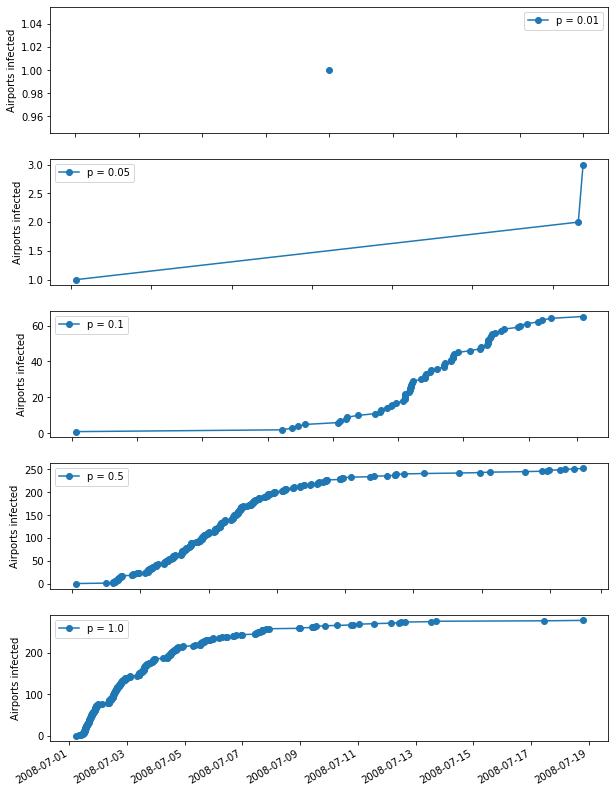

In [290]:
fmt = dates.DateFormatter("%Y-%m-%d")

fig, axs = plt.subplots(5, 1)

fig.set_figheight(15)
fig.set_figwidth(10)

for idx, infected in enumerate(infectedList):
  timeStamps = list(infected.keys())
  timeStamps.sort()

  axs[idx].set_ylabel('Airports infected')

  axs[idx].plot(timeStamps, np.arange(len(infected)) + 1, "-o", label="p = " + str(probabilities[idx]))

  axs[idx].xaxis.set_major_formatter(fmt)
  axs[idx].legend()
  fig.autofmt_xdate()

plt.show()

**ЧАСТЬ 3.**

При вероятности 0.01 инфекция не будет распространяться, при 0.05 тоже практически нет, а вот начиная с 0.1 инфекция начнет распространяться и заразит 23% аэропортов, при 0.5 - 90%, при 1 - все.

In [291]:
import networkx as nx

**Построение ненаправленного графа всех аэропортов.**

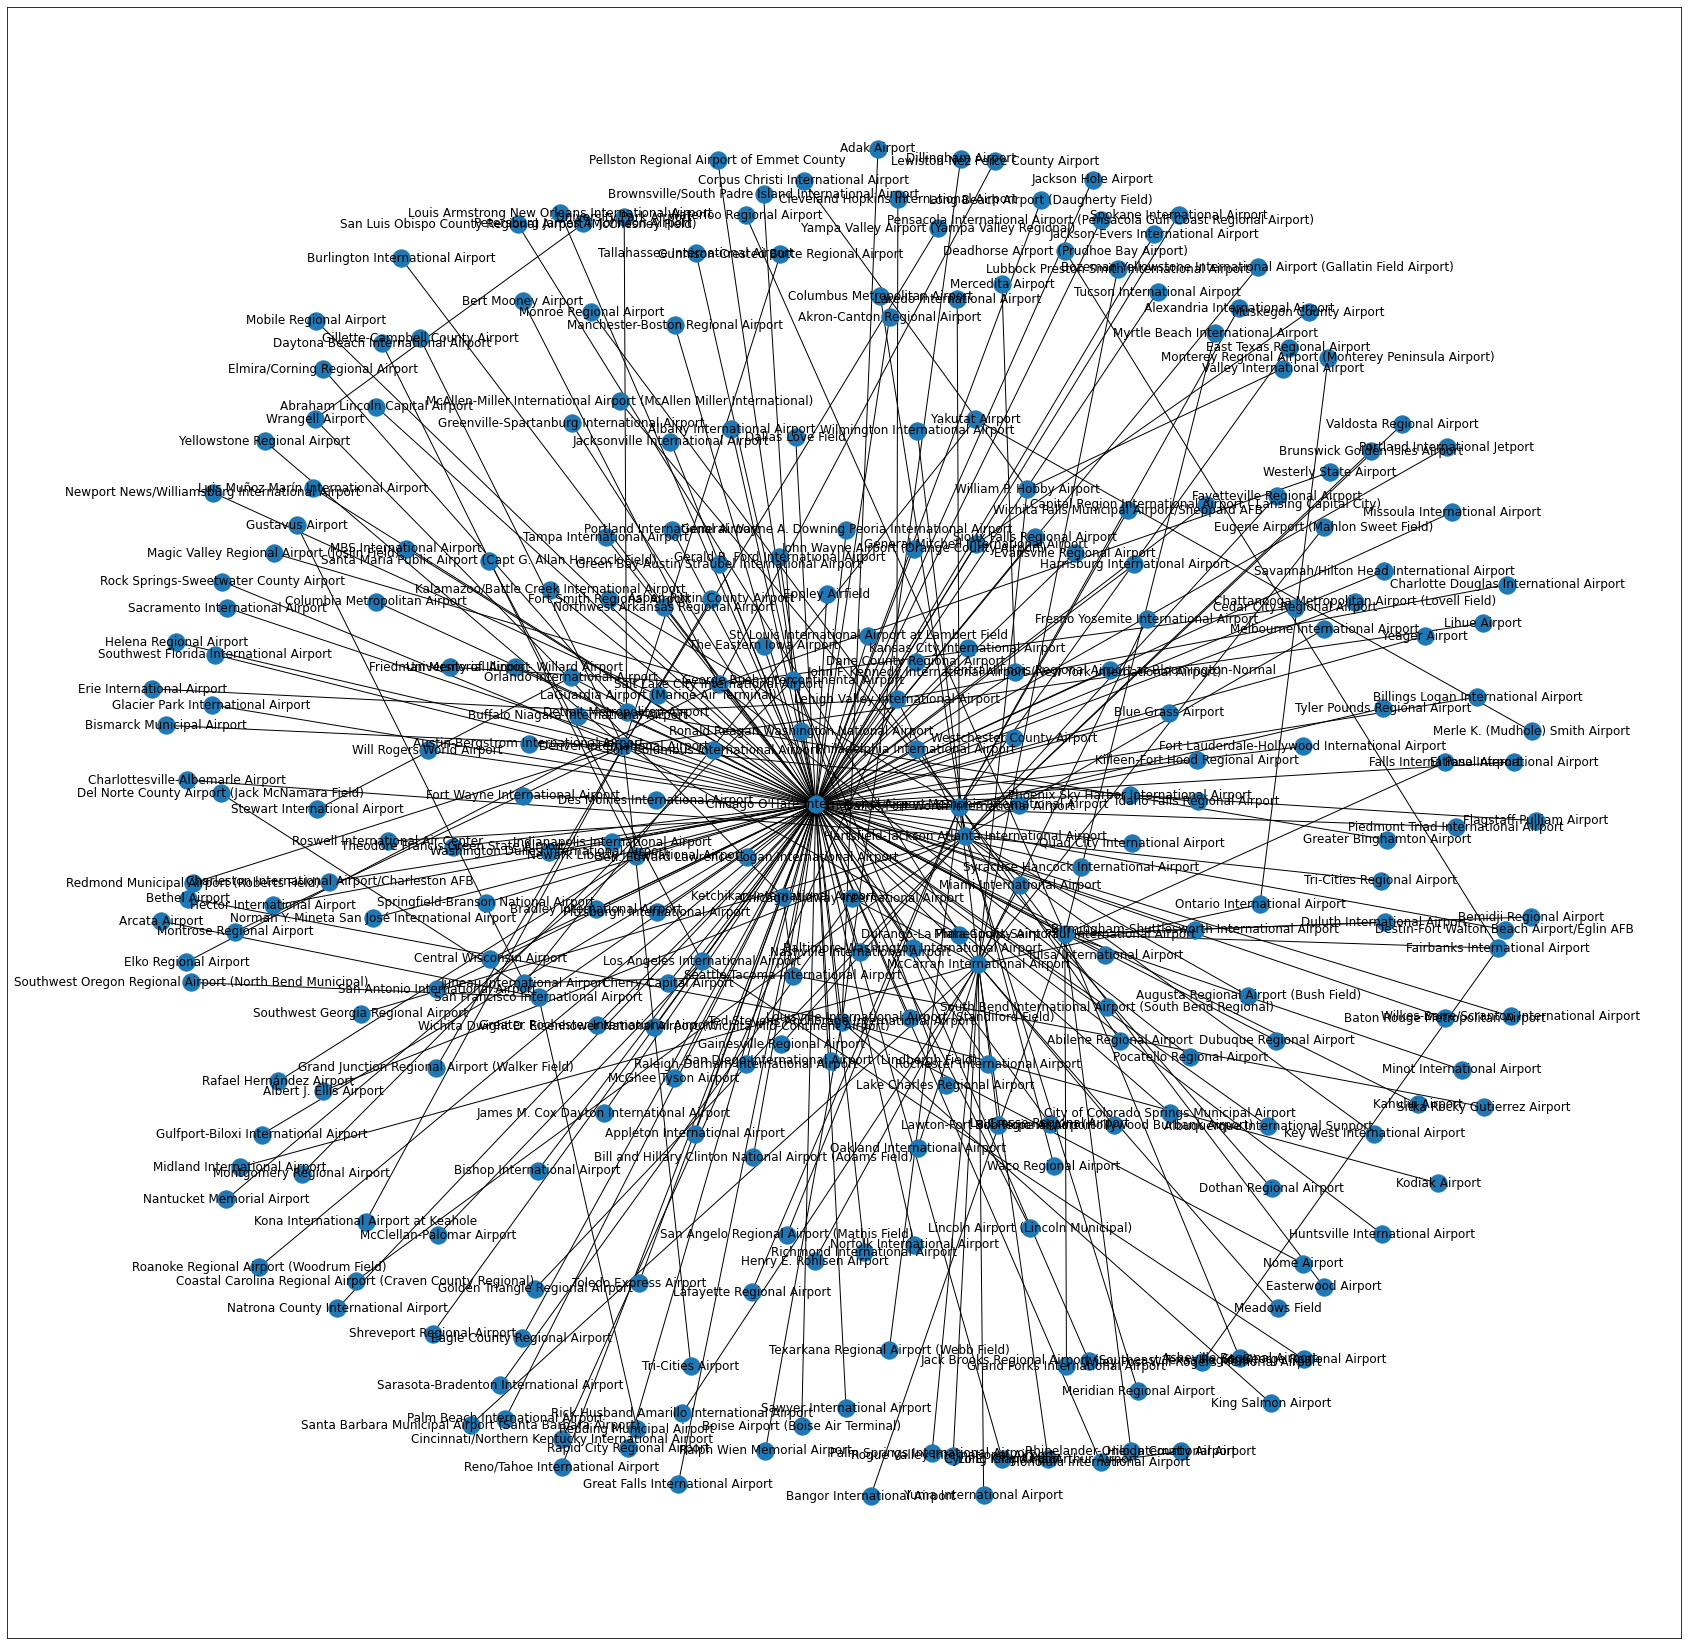

In [292]:
cityOrigin = "Allentown"

infected = {}
count_arriveies = {}
count_link_arriveies = {}

init_data = arr_data[arr_data[:, idx_AirPortOrigin] == cityOriginToAirPort[cityOrigin]]

infected[init_data[0][idx_DepDTime].to_pydatetime()] = cityOriginToAirPort[cityOrigin]  # 1-й зараженный аэропорт

buildInfectionInfo(init_data, arr_data.copy(), 1.0, cityOriginToAirPort[cityOrigin], count_arriveies, count_link_arriveies, infected)


total_arriveies = sum(list(count_link_arriveies.values()))  # Всего перелетов


edges = []

for airPortOrigin, airPortDest in list(count_link_arriveies.keys()):
  #print(airPortOrigin, airPortDest, count_link_arriveies[(airPortOrigin, airPortDest)])
  value = count_link_arriveies[(airPortOrigin, airPortDest)]
  reverse_value = 0
  if count_link_arriveies.get((airPortDest, airPortOrigin), None) != None:      # Есть обратный перелет
    reverse_value = count_link_arriveies[(airPortDest, airPortOrigin)]

    count_link_arriveies.pop((airPortDest, airPortOrigin))

  edges.append((airPortOrigin, airPortDest, (value + reverse_value) / total_arriveies))

G=nx.Graph()
G.add_weighted_edges_from(edges)  

nx.draw_networkx(G)

**Расчет медианного времени до заражения каждого аэропорта.**

In [293]:
infectedList = []
for n in range(50):         # Выполняем 50 симуляций для вероятности 0.5
  infected = spreadInfection("Allentown", 0.5)
  infectedList.append(infected)


In [294]:
airPortsInfected = []
for infected in infectedList:
  airPortsInfected += list(infected.values())

airPortsInfected = np.unique(airPortsInfected)

medianTimeStamps = {}
for airPortInfected in airPortsInfected:
  timeStamps = []
  for infected in infectedList:
    keys = list(infected.keys())
    values = list(infected.values())
    if not (airPortInfected in values): continue
    idx = values.index(airPortInfected)
    timeStamps.append(keys[idx])

  timeStamps.sort()

  if len(timeStamps) % 2 == 0:
    idx = len(timeStamps) // 2 - 1
  else:
    idx = (len(timeStamps) - 1) // 2

  medianTime = timeStamps[idx]

  medianTimeStamps[medianTime] = airPortInfected

medianTimeStamps

df_median_time = pd.DataFrame(data={"Median time": list(medianTimeStamps.keys()), "AirPort": list(medianTimeStamps.values())})
df_median_time.sort_values(by=["Median time"], inplace=True, ignore_index=True)
df_median_time[:30]

,Median time,AirPort
0,2008-07-01 05:32:59.000000,Lehigh Valley International Airport
1,2008-07-02 23:22:47.137946,Chicago O'Hare International Airport
2,2008-07-03 18:05:23.821351,Detroit Metropolitan Airport
3,2008-07-05 07:25:47.944702,Cleveland Hopkins International Airport
4,2008-07-05 08:19:48.181262,Hartsfield-Jackson Atlanta International Airport
5,2008-07-06 16:11:59.000000,Greater Binghamton Airport
6,2008-07-06 19:08:59.244590,LaGuardia Airport (Marine Air Terminal)
7,2008-07-06 23:10:12.153239,Dallas/Fort Worth International Airport
8,2008-07-07 13:32:23.900873,Minneapolis-Saint Paul International Airport
9,2008-07-07 17:21:00.880772,Los Angeles International Airport


**Расчет коэффициентов графа.**

In [295]:
np.array(list(nx.clustering(G).values()))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Кластеры отсуствуют.

In [296]:
items = []
for item in G.degree:
  items.append(item)

df_degree = pd.DataFrame(data=items, columns=["AirPort", "Degree"])
df_degree.sort_values(by=["Degree"], ascending=False, inplace=True, ignore_index=True)
print(df_degree[:15])
print(df_degree.tail())

                                             AirPort  Degree
0               Chicago O'Hare International Airport     137
1                     McCarran International Airport      18
2   Hartsfield-Jackson Atlanta International Airport      18
3            Dallas/Fort Worth International Airport      18
4                       Denver International Airport      17
5       Minneapolis-Saint Paul International Airport      12
6               Salt Lake City International Airport       9
7        Ted Stevens Anchorage International Airport       8
8                Lehigh Valley International Airport       6
9               George Bush Intercontinental Airport       6
10               San Francisco International Airport       5
11                      Detroit Metropolitan Airport       5
12                 Los Angeles International Airport       4
13              Seattle-Tacoma International Airport       4
14              Newark Liberty International Airport       4
                        

In [297]:
betweenness_centrality = nx.betweenness_centrality(G)

df_betw_centrality = pd.DataFrame(data={"AirPort": list(betweenness_centrality.keys()), "Betweenness Centrality": list(betweenness_centrality.values())})
df_betw_centrality.sort_values(by=["Betweenness Centrality"], ascending=False, inplace=True, ignore_index=True)
df_betw_centrality[:30]

,AirPort,Betweenness Centrality
0,Chicago O'Hare International Airport,0.970830
1,Lehigh Valley International Airport,0.175547
2,McCarran International Airport,0.146509
3,Dallas/Fort Worth International Airport,0.119605
4,Hartsfield-Jackson Atlanta International Airport,0.119605
5,Denver International Airport,0.112780
6,Minneapolis-Saint Paul International Airport,0.092069
7,Salt Lake City International Airport,0.057233
8,Seattle-Tacoma International Airport,0.056996
9,Ted Stevens Anchorage International Airport,0.050171


**Графики.**

In [298]:
plt.rcParams["figure.figsize"] = [15, 10]

**График медианного времени.**

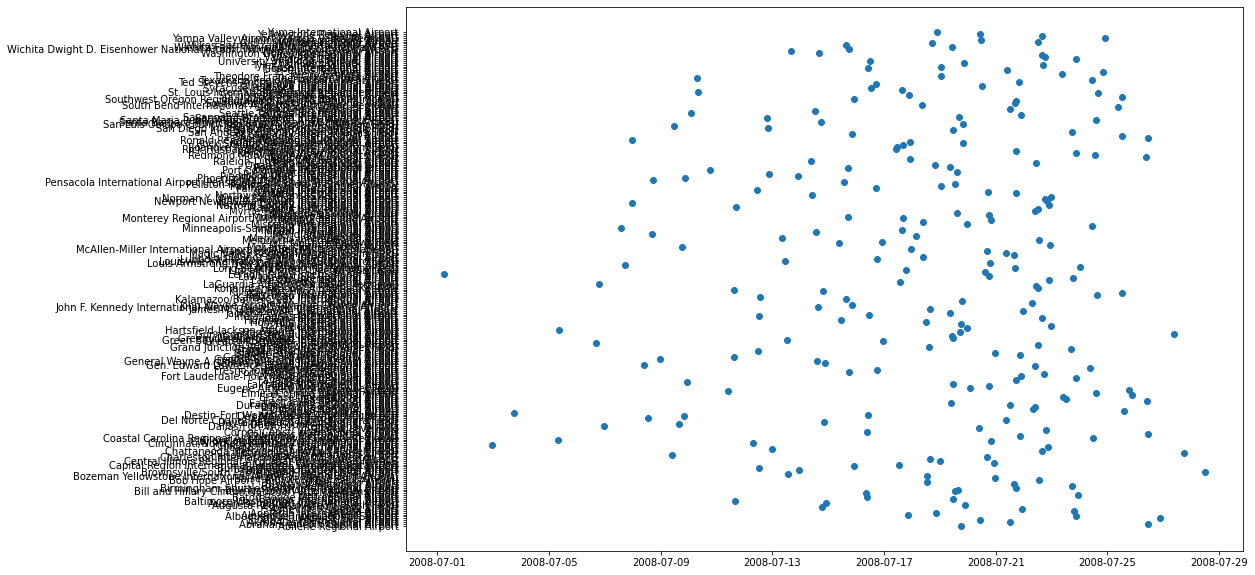

In [299]:
df_median_time.sort_values(by=["AirPort"], inplace=True, ignore_index=True)
plt.scatter(df_median_time.values[:, 0], df_median_time.values[:, 1])
plt.show()

**График степеней узлов.**

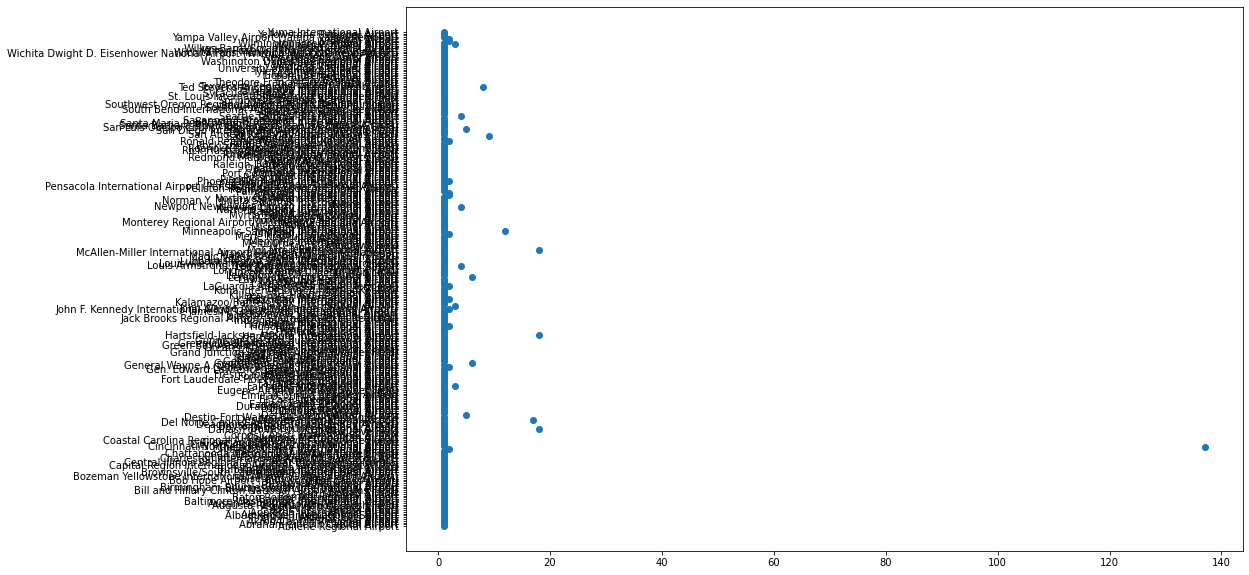

In [300]:
df_degree.sort_values(by=["AirPort"], inplace=True, ignore_index=True)
plt.scatter(df_degree["Degree"], df_degree["AirPort"])
plt.show()

**График центральности.**

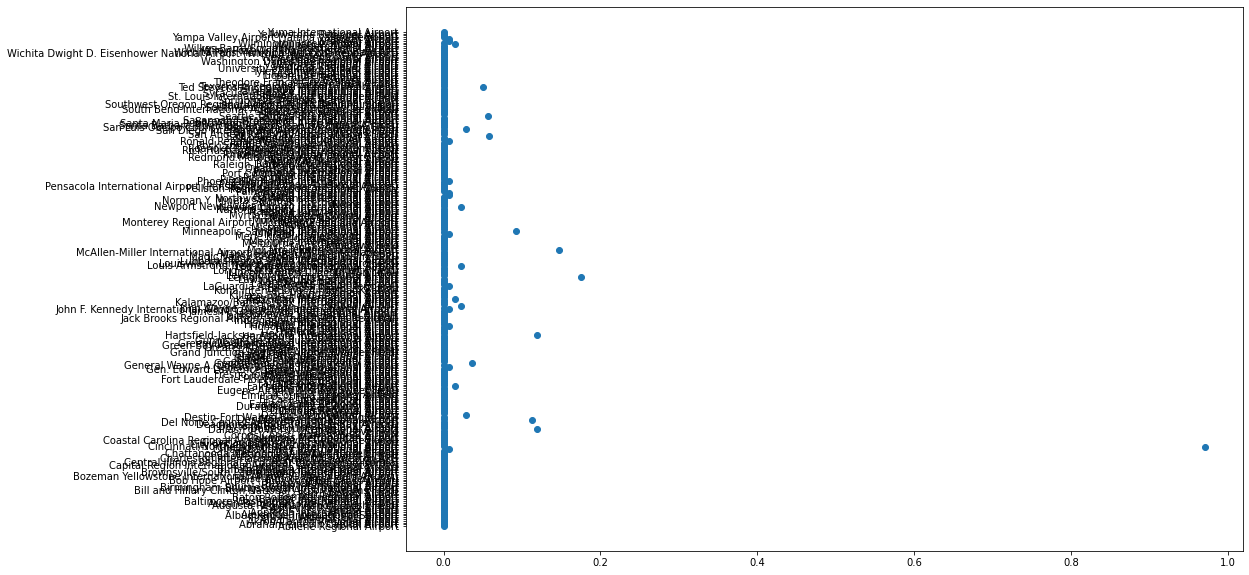

In [301]:
df_betw_centrality.sort_values(by=["AirPort"], inplace=True, ignore_index=True)

plt.scatter(df_betw_centrality["Betweenness Centrality"], df_betw_centrality["AirPort"])
plt.show()

**Коэффициент корреляции Спирмана.**

In [302]:
df = df_degree.merge(df_betw_centrality, on="AirPort")
df = df.merge(df_median_time, on="AirPort", how="left")

df.dropna(how="any", axis=0, inplace=True)

df = df[df["Degree"] > 1]

df.sort_values(by=["Degree"], ascending=False, inplace=True, ignore_index=True)
df[:30]

,AirPort,Degree,Betweenness Centrality,Median time
0,Chicago O'Hare International Airport,137,0.970830,2008-07-02 23:22:47.137946
1,Dallas/Fort Worth International Airport,18,0.119605,2008-07-06 23:10:12.153239
2,Hartsfield-Jackson Atlanta International Airport,18,0.119605,2008-07-05 08:19:48.181262
3,McCarran International Airport,18,0.146509,2008-07-09 18:19:12.618944
4,Denver International Airport,17,0.112780,2008-07-08 13:25:11.379096
5,Minneapolis-Saint Paul International Airport,12,0.092069,2008-07-07 13:32:23.900873
6,Salt Lake City International Airport,9,0.057233,2008-07-15 20:34:12.419583
7,Ted Stevens Anchorage International Airport,8,0.050171,2008-07-21 20:01:48.904841
8,Lehigh Valley International Airport,6,0.175547,2008-07-01 05:32:59.000000
9,George Bush Intercontinental Airport,6,0.035968,2008-07-08 23:32:23.166816


In [303]:
def convertTime_(dt):
  return dt.timestamp()

In [304]:
df["Median time"] = df["Median time"].apply(convertTime_)

In [305]:
df.corr('spearman')

,Degree,Betweenness Centrality,Median time
Degree,1.000000,0.967250,-0.518869
Betweenness Centrality,0.967250,1.000000,-0.515523
Median time,-0.518869,-0.515523,1.000000


Медианное время имеет практически одинаковую среднюю обратную корреляцию с degree и betweenness centrality, т.к. кластеризация всех узлов равно нулю, т.е. практически все самолеты выполняют маршрут до пункта назначения и обратно (видно на графе). Чем больше трафик через аэропорт, тем быстрее заражается аэропорт. Аэропорт Chicago O'Hare International Airport в июле является большим хабом.